
# Notebook 04: Feature Attribution Stability Score (FASS) Metric
# Purpose: Implement stability measurement using similarity metrics


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Check if repo exists, if not clone it
if not os.path.exists('/content/xai-stability-benchmark'):
    print("Repository not found. Creating directory structure...")
    os.makedirs('/content/xai-stability-benchmark', exist_ok=True)

%cd /content/xai-stability-benchmark

# Create necessary directories
!mkdir -p notebooks src data results figures

print("Directory structure ready")
print(f"Current directory: {os.getcwd()}")

Mounted at /content/drive
Repository not found. Creating directory structure...
/content/xai-stability-benchmark
Directory structure ready
Current directory: /content/xai-stability-benchmark


In [2]:
import torch
import torchvision
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

PyTorch version: 2.9.0+cu126
NumPy version: 2.0.2
Device: cuda


In [3]:
print("Loading pretrained ResNet-18...")
model = models.resnet18(pretrained=True).to(device)
model.eval()
print("Model loaded and set to evaluation mode")


Loading pretrained ResNet-18...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 242MB/s]


Model loaded and set to evaluation mode


In [4]:
!pip install -q scikit-image

from skimage.metrics import structural_similarity as ssim
from scipy.stats import spearmanr

print("Similarity metrics libraries imported")


Similarity metrics libraries imported


In [6]:

import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "captum"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scikit-image"])

print("Installed captum and scikit-image")

Installed captum and scikit-image


In [8]:
# Import Captum for XAI methods
from captum.attr import IntegratedGradients, Saliency, LayerGradCam, LayerAttribution

print("Captum imported")

# Base XAI wrapper class
class XAIMethod:
    """Base class for XAI methods"""
    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.method_name = "base"

    def preprocess(self, pil_image):
        """Convert PIL image to model input tensor"""
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
        return transform(pil_image).unsqueeze(0).to(self.device)

    def postprocess_attribution(self, attribution_tensor):
        """Convert attribution to numpy array"""
        if isinstance(attribution_tensor, torch.Tensor):
            attr = attribution_tensor.squeeze().cpu().detach().numpy()
        else:
            attr = np.array(attribution_tensor).squeeze()

        if len(attr.shape) == 3:
            attr = np.mean(np.abs(attr), axis=0)
        else:
            attr = np.abs(attr)

        return attr

# Integrated Gradients
class IntegratedGradientsMethod(XAIMethod):
    def __init__(self, model, device='cuda'):
        super().__init__(model, device)
        self.method_name = "integrated_gradients"
        self.ig = IntegratedGradients(model)

    def generate_attribution(self, input_tensor, target_class):
        input_tensor = input_tensor.clone().detach().requires_grad_(True)
        attributions = self.ig.attribute(input_tensor, target=target_class, n_steps=50)
        return self.postprocess_attribution(attributions)

# GradCAM
class GradCAMMethod(XAIMethod):
    def __init__(self, model, device='cuda'):
        super().__init__(model, device)
        self.method_name = "gradcam"
        self.gradcam = LayerGradCam(model, model.layer4[-1])

    def generate_attribution(self, input_tensor, target_class):
        attributions = self.gradcam.attribute(input_tensor, target=target_class)
        attributions = LayerAttribution.interpolate(attributions, input_tensor.shape[-2:])
        return self.postprocess_attribution(attributions)

# Vanilla Gradients
class VanillaGradientsMethod(XAIMethod):
    def __init__(self, model, device='cuda'):
        super().__init__(model, device)
        self.method_name = "vanilla_gradients"
        self.saliency = Saliency(model)

    def generate_attribution(self, input_tensor, target_class):
        input_tensor = input_tensor.clone().detach().requires_grad_(True)
        attributions = self.saliency.attribute(input_tensor, target=target_class)
        return self.postprocess_attribution(attributions)

print("XAI methods re-imported")

Captum imported
XAI methods re-imported


In [9]:
from PIL import ImageEnhance

class PerturbationGenerator:
    """Generate perturbations"""
    def __init__(self, image):
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        self.original_image = image

    def rotate(self, angle):
        return self.original_image.rotate(angle, fillcolor=(128, 128, 128))

    def translate(self, x_shift, y_shift):
        return self.original_image.transform(
            self.original_image.size, Image.AFFINE,
            (1, 0, x_shift, 0, 1, y_shift), fillcolor=(128, 128, 128))

    def add_gaussian_noise(self, sigma=0.01):
        img_array = np.array(self.original_image).astype(np.float32) / 255.0
        noise = np.random.normal(0, sigma, img_array.shape)
        noisy = np.clip(img_array + noise, 0, 1)
        return Image.fromarray((noisy * 255).astype(np.uint8))

    def adjust_brightness(self, factor):
        enhancer = ImageEnhance.Brightness(self.original_image)
        return enhancer.enhance(factor)

    def jpeg_compression(self, quality):
        from io import BytesIO
        buffer = BytesIO()
        self.original_image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        return Image.open(buffer)

    def generate_all_perturbations(self, config=None):
        if config is None:
            config = {
                'rotation': [-5, 5],
                'translation': [(-10, -10), (10, 10)],
                'noise_sigma': [0.01],
                'brightness': [0.9, 1.1],
                'jpeg_quality': [85]
            }

        perturbations = {'original': self.original_image}

        for angle in config['rotation']:
            perturbations[f'rotate_{angle}'] = self.rotate(angle)
        for i, (x, y) in enumerate(config['translation']):
            perturbations[f'translate_{i}'] = self.translate(x, y)
        for sigma in config['noise_sigma']:
            perturbations[f'noise_{sigma}'] = self.add_gaussian_noise(sigma)
        for factor in config['brightness']:
            perturbations[f'brightness_{factor}'] = self.adjust_brightness(factor)
        for quality in config['jpeg_quality']:
            perturbations[f'jpeg_{quality}'] = self.jpeg_compression(quality)

        return perturbations

print("Perturbation generator re-imported")


Perturbation generator re-imported


In [10]:
class SimilarityMetrics:
    """Calculate similarity between attribution maps"""

    @staticmethod
    def normalize_attribution(attr):
        """Normalize attribution map to [0, 1]"""
        attr_min = attr.min()
        attr_max = attr.max()
        if attr_max - attr_min > 0:
            return (attr - attr_min) / (attr_max - attr_min)
        return attr

    @staticmethod
    def ssim_similarity(attr1, attr2):
        """
        Structural Similarity Index (SSIM)
        Returns: float in [-1, 1], higher is more similar
        """
        # Normalize to [0, 1]
        attr1_norm = SimilarityMetrics.normalize_attribution(attr1)
        attr2_norm = SimilarityMetrics.normalize_attribution(attr2)

        # Ensure same shape
        if attr1_norm.shape != attr2_norm.shape:
            raise ValueError(f"Shape mismatch: {attr1_norm.shape} vs {attr2_norm.shape}")

        # Calculate SSIM
        score, _ = ssim(attr1_norm, attr2_norm, full=True, data_range=1.0)
        return score

    @staticmethod
    def spearman_similarity(attr1, attr2):
        """
        Spearman Rank Correlation
        Returns: float in [-1, 1]
        """
        # Flatten arrays
        flat1 = attr1.flatten()
        flat2 = attr2.flatten()

        # Calculate Spearman correlation
        corr, _ = spearmanr(flat1, flat2)

        # Handle NaN
        if np.isnan(corr):
            corr = 0.0

        return corr

    @staticmethod
    def top_k_overlap(attr1, attr2, k=100):
        """
        Top-K pixel overlap (Jaccard similarity)
        Returns: float in [0, 1]
        """
        # Flatten
        flat1 = attr1.flatten()
        flat2 = attr2.flatten()

        # Get top-k indices
        k = min(k, len(flat1))
        top_k1 = set(np.argsort(flat1)[-k:])
        top_k2 = set(np.argsort(flat2)[-k:])

        # Calculate Jaccard similarity
        intersection = len(top_k1 & top_k2)
        union = len(top_k1 | top_k2)

        return intersection / union if union > 0 else 0.0

    @staticmethod
    def combined_similarity(attr1, attr2, weights=None):
        """
        Combined similarity using all three metrics
        Returns: float in [0, 1]
        """
        if weights is None:
            weights = {'ssim': 1/3, 'spearman': 1/3, 'topk': 1/3}

        ssim_score = SimilarityMetrics.ssim_similarity(attr1, attr2)
        spearman_score = SimilarityMetrics.spearman_similarity(attr1, attr2)
        topk_score = SimilarityMetrics.top_k_overlap(attr1, attr2, k=100)

        # Convert to [0, 1] range (SSIM and Spearman can be negative)
        ssim_normalized = (ssim_score + 1) / 2
        spearman_normalized = (spearman_score + 1) / 2

        combined = (
            weights['ssim'] * ssim_normalized +
            weights['spearman'] * spearman_normalized +
            weights['topk'] * topk_score
        )

        return combined

print("Similarity metrics implemented")


Similarity metrics implemented


In [11]:
print("Testing similarity metrics...")

# Create two similar attribution maps
attr1 = np.random.rand(224, 224)
attr2 = attr1 + np.random.randn(224, 224) * 0.1  # Similar with noise

print(f"  SSIM: {SimilarityMetrics.ssim_similarity(attr1, attr2):.4f}")
print(f"  Spearman: {SimilarityMetrics.spearman_similarity(attr1, attr2):.4f}")
print(f"  Top-K Overlap: {SimilarityMetrics.top_k_overlap(attr1, attr2):.4f}")
print(f"  Combined: {SimilarityMetrics.combined_similarity(attr1, attr2):.4f}")

print("\nWith identical maps:")
print(f"  SSIM: {SimilarityMetrics.ssim_similarity(attr1, attr1):.4f}")
print(f"  Combined: {SimilarityMetrics.combined_similarity(attr1, attr1):.4f}")

print("\n Similarity metrics work correctly!")

Testing similarity metrics...
  SSIM: 0.8258
  Spearman: 0.9485
  Top-K Overlap: 0.0101
  Combined: 0.6324

With identical maps:
  SSIM: 1.0000
  Combined: 1.0000

 Similarity metrics work correctly!


In [12]:
class FASSCalculator:
    """Calculate Feature Attribution Stability Score"""

    def __init__(self, xai_method, similarity_weights=None):
        """
        Args:
            xai_method: XAIMethod instance
            similarity_weights: weights for similarity metrics
        """
        self.xai_method = xai_method
        self.similarity_weights = similarity_weights

    def compute_fass_for_image(self, original_image, perturbations_dict, target_class):
        """
        Compute FASS for one image and its perturbations

        Args:
            original_image: PIL Image (original)
            perturbations_dict: dict {name: perturbed_PIL_image}
            target_class: int, target class for attribution

        Returns:
            dict with FASS score and detailed results
        """
        # Generate attributions for all images
        attributions = {}

        print(f"  Generating attributions for {len(perturbations_dict)} images...")
        for name, img in perturbations_dict.items():
            input_tensor = self.xai_method.preprocess(img)
            attr = self.xai_method.generate_attribution(input_tensor, target_class)
            attributions[name] = attr

        # Calculate pairwise similarities
        names = list(attributions.keys())
        similarities = []

        for i in range(len(names)):
            for j in range(i + 1, len(names)):
                sim = SimilarityMetrics.combined_similarity(
                    attributions[names[i]],
                    attributions[names[j]],
                    weights=self.similarity_weights
                )
                similarities.append({
                    'pair': (names[i], names[j]),
                    'similarity': sim
                })

        # Calculate FASS (average of pairwise similarities)
        fass_score = np.mean([s['similarity'] for s in similarities])

        return {
            'fass_score': fass_score,
            'pairwise_similarities': similarities,
            'attributions': attributions,
            'num_perturbations': len(perturbations_dict)
        }

    def compute_fass_dataset(self, images_and_perturbations, target_classes):
        """
        Compute FASS for multiple images

        Args:
            images_and_perturbations: list of (original_img, perturbations_dict)
            target_classes: list of target classes

        Returns:
            dict with aggregate statistics
        """
        fass_scores = []
        detailed_results = []

        for idx, ((original_img, perturbs_dict), target_class) in enumerate(
            zip(images_and_perturbations, target_classes)
        ):
            print(f"\nProcessing image {idx + 1}/{len(images_and_perturbations)}...")
            result = self.compute_fass_for_image(original_img, perturbs_dict, target_class)
            fass_scores.append(result['fass_score'])
            detailed_results.append(result)
            print(f"  FASS: {result['fass_score']:.4f}")

        return {
            'mean_fass': np.mean(fass_scores),
            'std_fass': np.std(fass_scores),
            'median_fass': np.median(fass_scores),
            'min_fass': np.min(fass_scores),
            'max_fass': np.max(fass_scores),
            'all_scores': fass_scores,
            'detailed_results': detailed_results
        }

print("FASS calculator implemented")


FASS calculator implemented


Downloaded test image: (224, 224)


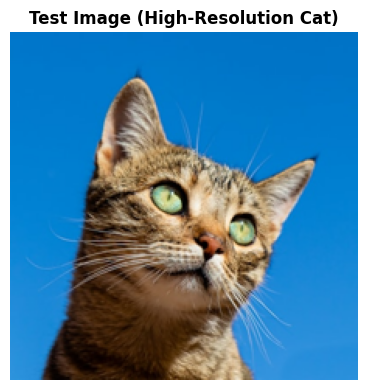

In [13]:
print("Downloading test image...")

import requests
from io import BytesIO

def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

test_url = 'https://images.unsplash.com/photo-1574158622682-e40e69881006?w=400'
test_image = download_image(test_url).convert('RGB')
test_image = test_image.resize((224, 224))

print(f"Downloaded test image: {test_image.size}")

# Display test image
plt.figure(figsize=(4, 4))
plt.imshow(test_image)
plt.title('Test Image (High-Resolution Cat)', fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/fass_test_image.png', dpi=150, bbox_inches='tight')
plt.show()


In [14]:
print("Generating perturbations...")

perturb_gen = PerturbationGenerator(test_image)
perturbations = perturb_gen.generate_all_perturbations()

print(f"Generated {len(perturbations)} versions (1 original + {len(perturbations)-1} perturbations)")
print(f"  Perturbation types: {list(perturbations.keys())}")


Generating perturbations...
Generated 9 versions (1 original + 8 perturbations)
  Perturbation types: ['original', 'rotate_-5', 'rotate_5', 'translate_0', 'translate_1', 'noise_0.01', 'brightness_0.9', 'brightness_1.1', 'jpeg_85']


In [16]:
print("\nGetting model prediction...")

xai_method = IntegratedGradientsMethod(model, device)
test_input = xai_method.preprocess(test_image)

with torch.no_grad():
    output = model(test_input)
    pred_class = output.argmax(dim=1).item()
    confidence = torch.nn.functional.softmax(output, dim=1).max().item()

print(f"Predicted class: {pred_class}")
print(f"  Confidence: {confidence:.4f}")


Getting model prediction...
Predicted class: 281
  Confidence: 0.6165


In [17]:
print("\n" + "="*60)
print("COMPUTING FASS SCORE")
print("="*60)

fass_calc = FASSCalculator(xai_method)
result = fass_calc.compute_fass_for_image(test_image, perturbations, pred_class)

print("\n" + "="*60)
print(f"FASS SCORE: {result['fass_score']:.4f}")
print("="*60)
print(f"Number of perturbations: {result['num_perturbations']}")
print(f"Number of pairwise comparisons: {len(result['pairwise_similarities'])}")

# Show sample pairwise similarities
print(f"\nSample pairwise similarities:")
for sim_dict in result['pairwise_similarities'][:5]:
    pair = sim_dict['pair']
    sim = sim_dict['similarity']
    print(f"  {pair[0]:20s} ↔ {pair[1]:20s}: {sim:.4f}")



COMPUTING FASS SCORE
  Generating attributions for 9 images...

FASS SCORE: 0.4624
Number of perturbations: 9
Number of pairwise comparisons: 36

Sample pairwise similarities:
  original             ↔ rotate_-5           : 0.4247
  original             ↔ rotate_5            : 0.4123
  original             ↔ translate_0         : 0.3987
  original             ↔ translate_1         : 0.3919
  original             ↔ noise_0.01          : 0.6218



Creating visualization...


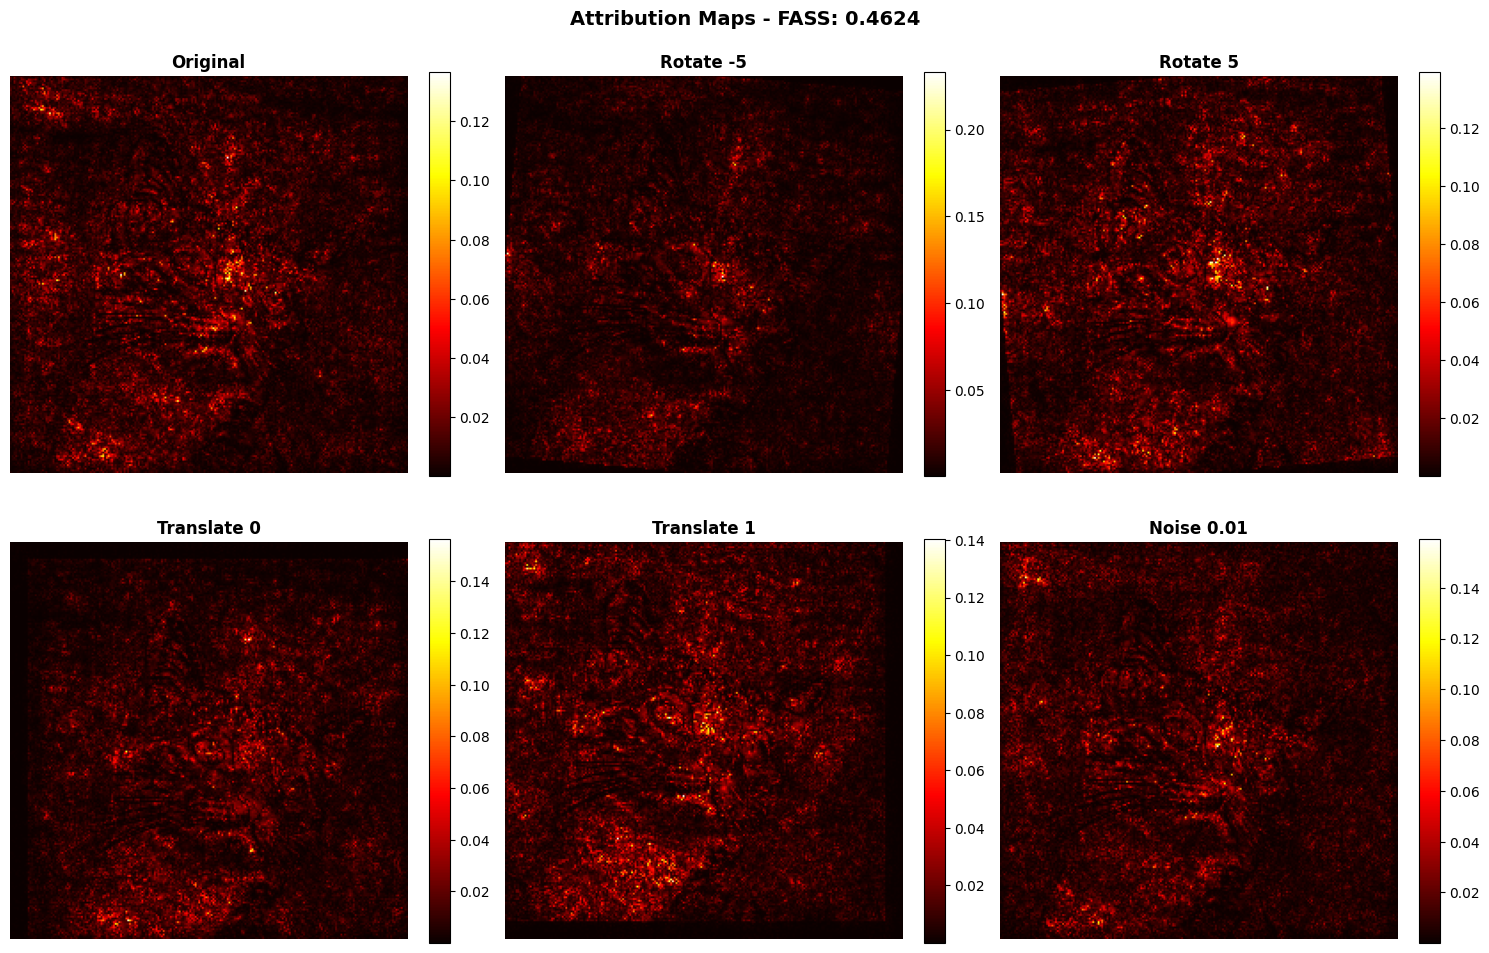

Visualization saved to figures/fass_attributions_example.png


In [18]:
print("\nCreating visualization...")

attributions = result['attributions']
attr_names = list(attributions.keys())[:6]  # Show first 6

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, name in enumerate(attr_names):
    attr = attributions[name]
    im = axes[idx].imshow(attr, cmap='hot')
    axes[idx].set_title(name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046)

plt.suptitle(f'Attribution Maps - FASS: {result["fass_score"]:.4f}',
             fontsize=14, fontweight='bold')
plt.tight_layout()

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/fass_attributions_example.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to figures/fass_attributions_example.png")

In [19]:
print("\n" + "="*60)
print("COMPARING FASS ACROSS XAI METHODS")
print("="*60)

# Create methods
methods = {
    'Integrated Gradients': IntegratedGradientsMethod(model, device),
    'Vanilla Gradients': VanillaGradientsMethod(model, device),
    'GradCAM': GradCAMMethod(model, device)
}

# Compute FASS for each method
fass_comparison = {}

for method_name, xai_method in methods.items():
    print(f"\nComputing FASS for {method_name}...")
    fass_calc = FASSCalculator(xai_method)
    result = fass_calc.compute_fass_for_image(test_image, perturbations, pred_class)
    fass_comparison[method_name] = result['fass_score']
    print(f"  → FASS: {result['fass_score']:.4f}")



COMPARING FASS ACROSS XAI METHODS

Computing FASS for Integrated Gradients...
  Generating attributions for 9 images...
  → FASS: 0.4624

Computing FASS for Vanilla Gradients...
  Generating attributions for 9 images...
  → FASS: 0.4295

Computing FASS for GradCAM...
  Generating attributions for 9 images...
  → FASS: 0.6796



Creating comparison visualization...


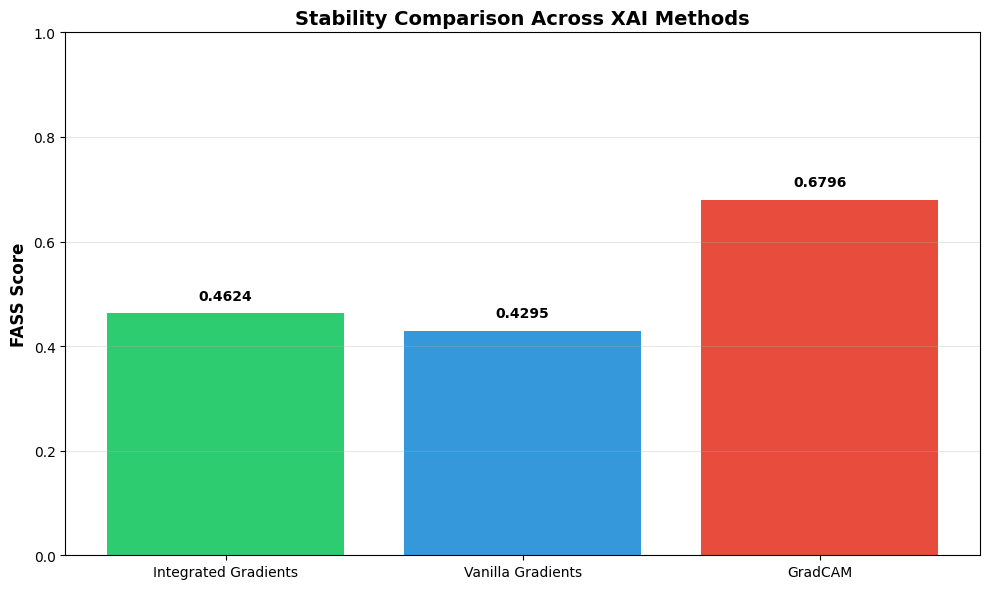

Comparison saved to figures/fass_method_comparison.png


In [20]:
print("\nCreating comparison visualization...")

fig, ax = plt.subplots(figsize=(10, 6))
methods_list = list(fass_comparison.keys())
scores_list = list(fass_comparison.values())

colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax.bar(methods_list, scores_list, color=colors)

ax.set_ylabel('FASS Score', fontsize=12, fontweight='bold')
ax.set_title('Stability Comparison Across XAI Methods', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, scores_list):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('figures/fass_method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Comparison saved to figures/fass_method_comparison.png")

In [21]:
print("\n" + "="*60)
print("TESTING BATCH PROCESSING")
print("="*60)

# Create 5 test images with perturbations
batch_data = []
batch_targets = []

print("Preparing batch of 5 images...")
for i in range(5):
    # Use same test image for demo (in practice, use different images)
    perturbs = perturb_gen.generate_all_perturbations()
    batch_data.append((test_image, perturbs))
    batch_targets.append(pred_class)

# Compute FASS for batch
print(f"\nProcessing batch with Integrated Gradients...")
fass_calc = FASSCalculator(IntegratedGradientsMethod(model, device))
batch_results = fass_calc.compute_fass_dataset(batch_data, batch_targets)

print("\n" + "="*60)
print("BATCH FASS RESULTS")
print("="*60)
print(f"Mean FASS:   {batch_results['mean_fass']:.4f}")
print(f"Std Dev:     {batch_results['std_fass']:.4f}")
print(f"Median:      {batch_results['median_fass']:.4f}")
print(f"Min:         {batch_results['min_fass']:.4f}")
print(f"Max:         {batch_results['max_fass']:.4f}")
print("="*60)



TESTING BATCH PROCESSING
Preparing batch of 5 images...

Processing batch with Integrated Gradients...

Processing image 1/5...
  Generating attributions for 9 images...
  FASS: 0.4621

Processing image 2/5...
  Generating attributions for 9 images...
  FASS: 0.4635

Processing image 3/5...
  Generating attributions for 9 images...
  FASS: 0.4596

Processing image 4/5...
  Generating attributions for 9 images...
  FASS: 0.4611

Processing image 5/5...
  Generating attributions for 9 images...
  FASS: 0.4619

BATCH FASS RESULTS
Mean FASS:   0.4616
Std Dev:     0.0013
Median:      0.4619
Min:         0.4596
Max:         0.4635


In [22]:
fass_config = {
    'similarity_metrics': ['ssim', 'spearman', 'top_k_overlap'],
    'similarity_weights': {
        'ssim': 1/3,
        'spearman': 1/3,
        'topk': 1/3
    },
    'top_k_value': 100,
    'perturbation_config': {
        'rotation': [-5, 5],
        'translation': [(-10, -10), (10, 10)],
        'noise_sigma': [0.01],
        'brightness': [0.9, 1.1],
        'jpeg_quality': [85]
    },
    'normalization': 'min-max to [0,1]',
    'xai_methods_tested': list(fass_comparison.keys()),
    'example_fass_scores': fass_comparison
}

os.makedirs('results', exist_ok=True)
with open('results/fass_config.json', 'w') as f:
    json.dump(fass_config, f, indent=2)

print("\n FASS configuration saved to results/fass_config.json")


 FASS configuration saved to results/fass_config.json
